In [1]:
# 匯入所需的庫
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy import stats

# 讀取數據
path = '/Users/mouyasushi/Desktop/Machine Learning /skl_cs/crypto/Alpha-Research/ML/agg_data.parquet'
df = pq.read_table(path).to_pandas()
print(f"數據集形狀: {df.shape}")
print("\n數據集前5行:")
df.head()



數據集形狀: (31878, 44)

數據集前5行:


,symbol,open_time,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,...,ema_14,ema_30,ema_90,atr_7,atr_14,atr_21,macd_line,macd_signal,macd_histogram,alpha1
0,AAVEUSDT,2021-01-01,88.581,91.000,84.652,90.909,368132.6,3.236081e+07,95220,160420.1,...,NaN,NaN,90.909000,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN
1,AAVEUSDT,2021-01-02,90.940,92.200,82.573,85.888,350675.1,3.019238e+07,96482,141557.9,...,NaN,NaN,90.798648,NaN,NaN,NaN,-0.400536,-0.080107,-0.320428,NaN
2,AAVEUSDT,2021-01-03,85.911,95.680,81.338,94.185,490412.4,4.367915e+07,120659,219913.4,...,NaN,NaN,90.873074,NaN,NaN,NaN,-0.047912,-0.073668,0.025756,NaN
3,AAVEUSDT,2021-01-04,94.183,115.590,85.932,114.322,1108493.1,1.136470e+08,301713,514642.8,...,NaN,NaN,91.388435,NaN,NaN,NaN,1.835276,0.308121,1.527155,NaN
4,AAVEUSDT,2021-01-05,114.344,124.279,98.653,119.800,843809.1,9.551636e+07,271640,385402.1,...,NaN,NaN,92.012865,NaN,NaN,NaN,3.726785,0.991854,2.734932,NaN


In [2]:
df['daily_return'].isnull().sum()

21

In [3]:
df = df.dropna(subset=['daily_return'])
df['open_time'] = pd.to_datetime(df['open_time'])


In [4]:
feature_cols = ['open', 'high', 'low', 'close', 'volume',
       'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume',
       'taker_buy_quote_asset_volume',
       'volatility_7d', 'volatility_14d', 'volatility_30d', 'typical_price',
       'tp_vol', 'vwap_7d', 'vwap_14d', 'vwap_30d', 'vwap_7d_diff',
       'vwap_14d_diff', 'vwap_30d_diff', 'vwap_7d_trend',
       'vwap_7d_trend_direction', 'vwap_14d_trend', 'vwap_14d_trend_direction',
       'vwap_30d_trend', 'vwap_30d_trend_direction', 'rsi_7', 'rsi_14',
       'rsi_21', 'ema_7', 'ema_14', 'ema_30', 'ema_90', 'atr_7', 'atr_14',
       'atr_21', 'macd_line', 'macd_signal', 'macd_histogram', 'alpha1']

target_col = 'daily_return'


In [5]:
missing_values = df[feature_cols + [target_col]].isnull().sum()

if missing_values.sum() > 0:
    print("\n缺失值情況:")
    print(missing_values[missing_values > 0])
    # 填充缺失值或移除含缺失值的行
    df = df.dropna(subset=feature_cols + [target_col])


缺失值情況:
volatility_7d     126
volatility_14d    273
volatility_30d    609
vwap_7d           105
vwap_14d          252
vwap_30d          588
vwap_7d_diff      105
vwap_14d_diff     252
vwap_30d_diff     588
vwap_7d_trend     126
vwap_14d_trend    273
vwap_30d_trend    609
rsi_7             105
rsi_14            252
rsi_21            399
ema_7             105
ema_14            252
ema_30            588
atr_7             105
atr_14            252
atr_21            399
alpha1            546
dtype: int64


In [6]:
len(df)  # some row had droped 


31248

check feature type 

In [7]:
df['vwap_7d_trend_direction']

30         Up
31         Up
32         Up
33         Up
34         Up
         ... 
31873    Down
31874    Down
31875    Down
31876    Down
31877    Down
Name: vwap_7d_trend_direction, Length: 31248, dtype: object

In [8]:
# 檢查每個特徵欄位的數據類型
for col in feature_cols:
    unique_values = df[col].unique()
    if df[col].dtype == 'object' or 'str' in str(df[col].dtype):
        print(f"col '{col}': {df[col].dtype}")
        print(f"  unique val: {unique_values[:5]}... (tot{len(unique_values)}個)")
        print(f"  Non numerical data!")

col 'vwap_7d_trend_direction': object
  unique val: ['Up' 'Down']... (tot2個)
  Non numerical data!
col 'vwap_14d_trend_direction': object
  unique val: ['Up' 'Down']... (tot2個)
  Non numerical data!
col 'vwap_30d_trend_direction': object
  unique val: ['Up' 'Down']... (tot2個)
  Non numerical data!


In [9]:
trend_mapping = {
    'Up': 1,
    'Down': 0,
}

# 直接將包含 'Up'/'Down' 的列映射到數值
df['vwap_7d_trend_direction'] = df['vwap_7d_trend_direction'].map(trend_mapping)
df['vwap_14d_trend_direction'] = df['vwap_14d_trend_direction'].map(trend_mapping)
df['vwap_30d_trend_direction'] = df['vwap_30d_trend_direction'].map(trend_mapping)

# 檢查結果
print(df['vwap_7d_trend_direction'].value_counts())

vwap_7d_trend_direction
0    15710
1    15538
Name: count, dtype: int64


# after dropping Nan values 

- train : 2021/01/31 - 2024/10/01  
    - 28140
- test : 2024/10/2 - 2025/02/26 
    - 3108 

In [10]:

cutoff_date = df['open_time'].sort_values().iloc[-int(len(df)/10)]  # 使用最後10%的數據作為測試集
train_data = df[df['open_time'] <= cutoff_date]
test_data = df[df['open_time'] > cutoff_date]

print(f"\n訓練集形狀: {train_data.shape}")
print(f"測試集形狀: {test_data.shape}")

test_data[test_data['symbol']=='AAVEUSDT']


訓練集形狀: (28140, 44)
測試集形狀: (3108, 44)


,symbol,open_time,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,...,ema_14,ema_30,ema_90,atr_7,atr_14,atr_21,macd_line,macd_signal,macd_histogram,alpha1
1370,AAVEUSDT,2024-10-02,144.71,150.13,136.70,139.06,1262141.1,1.803299e+08,613522,613203.4,...,154.104280,147.825094,127.531782,11.503710,11.084559,10.827651,4.727082,7.823684,-3.096602,-0.120399
1371,AAVEUSDT,2024-10-03,139.07,146.84,134.56,143.60,1822593.2,2.561171e+08,799074,924365.4,...,152.703709,147.552507,127.884930,11.614609,11.169948,10.896810,3.518472,6.962642,-3.444170,-0.066105
1372,AAVEUSDT,2024-10-04,143.60,152.78,141.42,151.23,1512159.6,2.244012e+08,704977,737650.6,...,152.507215,147.789764,128.398008,11.578236,11.183523,10.918867,3.140120,6.198137,-3.058018,0.047292
1373,AAVEUSDT,2024-10-05,151.22,151.77,145.92,148.39,495936.9,7.398844e+07,277973,234834.1,...,151.958253,147.828489,128.837393,10.759917,10.802557,10.677492,2.581352,5.474780,-2.893428,0.123391
1374,AAVEUSDT,2024-10-06,148.40,150.50,146.10,150.06,508739.8,7.539962e+07,273963,243435.6,...,151.705152,147.972458,129.303824,9.851357,10.345232,10.378564,2.247374,4.829299,-2.581925,0.221132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1513,AAVEUSDT,2025-02-22,242.59,251.49,238.80,246.98,493308.0,1.209052e+08,518534,240721.9,...,255.219303,268.048291,268.906077,20.337630,24.140974,26.136798,-11.266186,-12.934859,1.668673,0.242493
1514,AAVEUSDT,2025-02-23,246.97,254.16,242.83,247.49,376516.1,9.320594e+07,424164,179565.9,...,254.188729,266.721950,268.435394,19.050825,23.225905,25.431713,-10.938300,-12.535547,1.597248,0.171580
1515,AAVEUSDT,2025-02-24,247.50,249.20,205.00,210.63,1014514.9,2.303340e+08,903091,479693.3,...,248.380899,263.103115,267.164946,22.643565,24.724054,26.325441,-13.497155,-12.727869,-0.769286,0.200758
1516,AAVEUSDT,2025-02-25,210.62,213.46,189.37,205.04,1735893.4,3.460300e+08,1386922,853259.5,...,242.602112,259.357107,265.799562,22.850198,24.678765,26.218991,-15.794068,-13.341109,-2.452959,0.211044


In [11]:
X_train = train_data[feature_cols].values
y_train = train_data[target_col].values

# 提取測試集的X和Y
X_test = test_data[feature_cols].values
y_test = test_data[target_col].values

In [12]:
X_train

array([[3.15445000e+02, 3.20596000e+02, 2.93000000e+02, ...,
        3.95525712e+01, 7.92390973e+00, 7.41802343e-02],
       [3.00021000e+02, 3.07127000e+02, 2.84000000e+02, ...,
        4.09943627e+01, 5.76716581e+00, 5.08084795e-02],
       [2.95422000e+02, 3.10380000e+02, 2.86000000e+02, ...,
        4.20493081e+01, 4.21978156e+00, 5.08084795e-02],
       ...,
       [7.41000000e-01, 7.57000000e-01, 7.27000000e-01, ...,
        1.31784641e-02, 9.64985350e-03, 2.71011064e-01],
       [7.44000000e-01, 7.47000000e-01, 6.99000000e-01, ...,
        1.46568113e-02, 5.91338872e-03, 1.92071008e-01],
       [7.04000000e-01, 7.18000000e-01, 6.41000000e-01, ...,
        1.46889117e-02, 1.28401822e-04, 1.55083115e-01]])

RMSE train 

In [13]:
# 1. 使用訓練集進行回歸並計算RMSEtrain、杠桿分數hii和留一法預測差異
# 訓練模型
model = LinearRegression()
model.fit(X_train, y_train)

# 訓練集預測
y_pred_train = model.predict(X_train)

# 計算訓練集RMSE ( root mean square error)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
print(f"\ntrainRMSE: {rmse_train:.4f}")




trainRMSE: 0.0383


leverage score 

In [14]:
# 計算杠桿分數 (leverage scores) hii
# 計算帽子矩陣 H = X(X'X)^(-1)X'

# 添加截距項(1)
X_train_with_intercept = np.column_stack([np.ones(X_train.shape[0]), X_train])
# 計算帽子矩陣 H = X(X'X)^(-1)X'
hat_matrix = X_train_with_intercept @ np.linalg.inv(X_train_with_intercept.T @ X_train_with_intercept) @ X_train_with_intercept.T
# 提取對角線元素(hii)
leverage_scores = np.diag(hat_matrix) 



LOO predictioin difference 

In [15]:
n = X_train.shape[0]
y_loo_pred = np.zeros(n)


# 根據公式：ŷ(-i) = (yi - ŷi*hii)/(1-hii)
for i in range(n):
    if leverage_scores[i] != 1:  # 避免除以零
        y_loo_pred[i] = (y_train[i] - y_pred_train[i] * leverage_scores[i]) / (1 - leverage_scores[i])
    else:
        y_loo_pred[i] = y_pred_train[i]  # 如果hii=1，使用原預測

# 計算留一法預測差異 |ŷi - ŷ(-i)|
y_loo_diff = np.abs(y_pred_train - y_loo_pred)

In [ ]:
y_loo_diff.sort()  # 越後面會越大

In [19]:
y_loo_diff[-3:]

array([0.45566303, 0.47624164, 0.51443754])

###  2. 報告統計量


杠桿分數(hii)統計量:
最小值: 0.000019
1%分位數: 0.000214
25%分位數: 0.000378
中位數: 0.000506
75%分位數: 0.000769
99%分位數: 0.021039
最大值: 0.321815

留一法預測差異(|ŷi - ŷ(-i)|)統計量:
最小值: 0.000000
1%分位數: 0.000347
25%分位數: 0.008253
中位數: 0.018340
75%分位數: 0.034708
99%分位數: 0.130517
最大值: 0.514438
----------------------------------------------------------------------------------------------------

杠桿分數閾值 (2P/N): 0.002843
杠桿分數超過閾值的觀測值數量: 1838


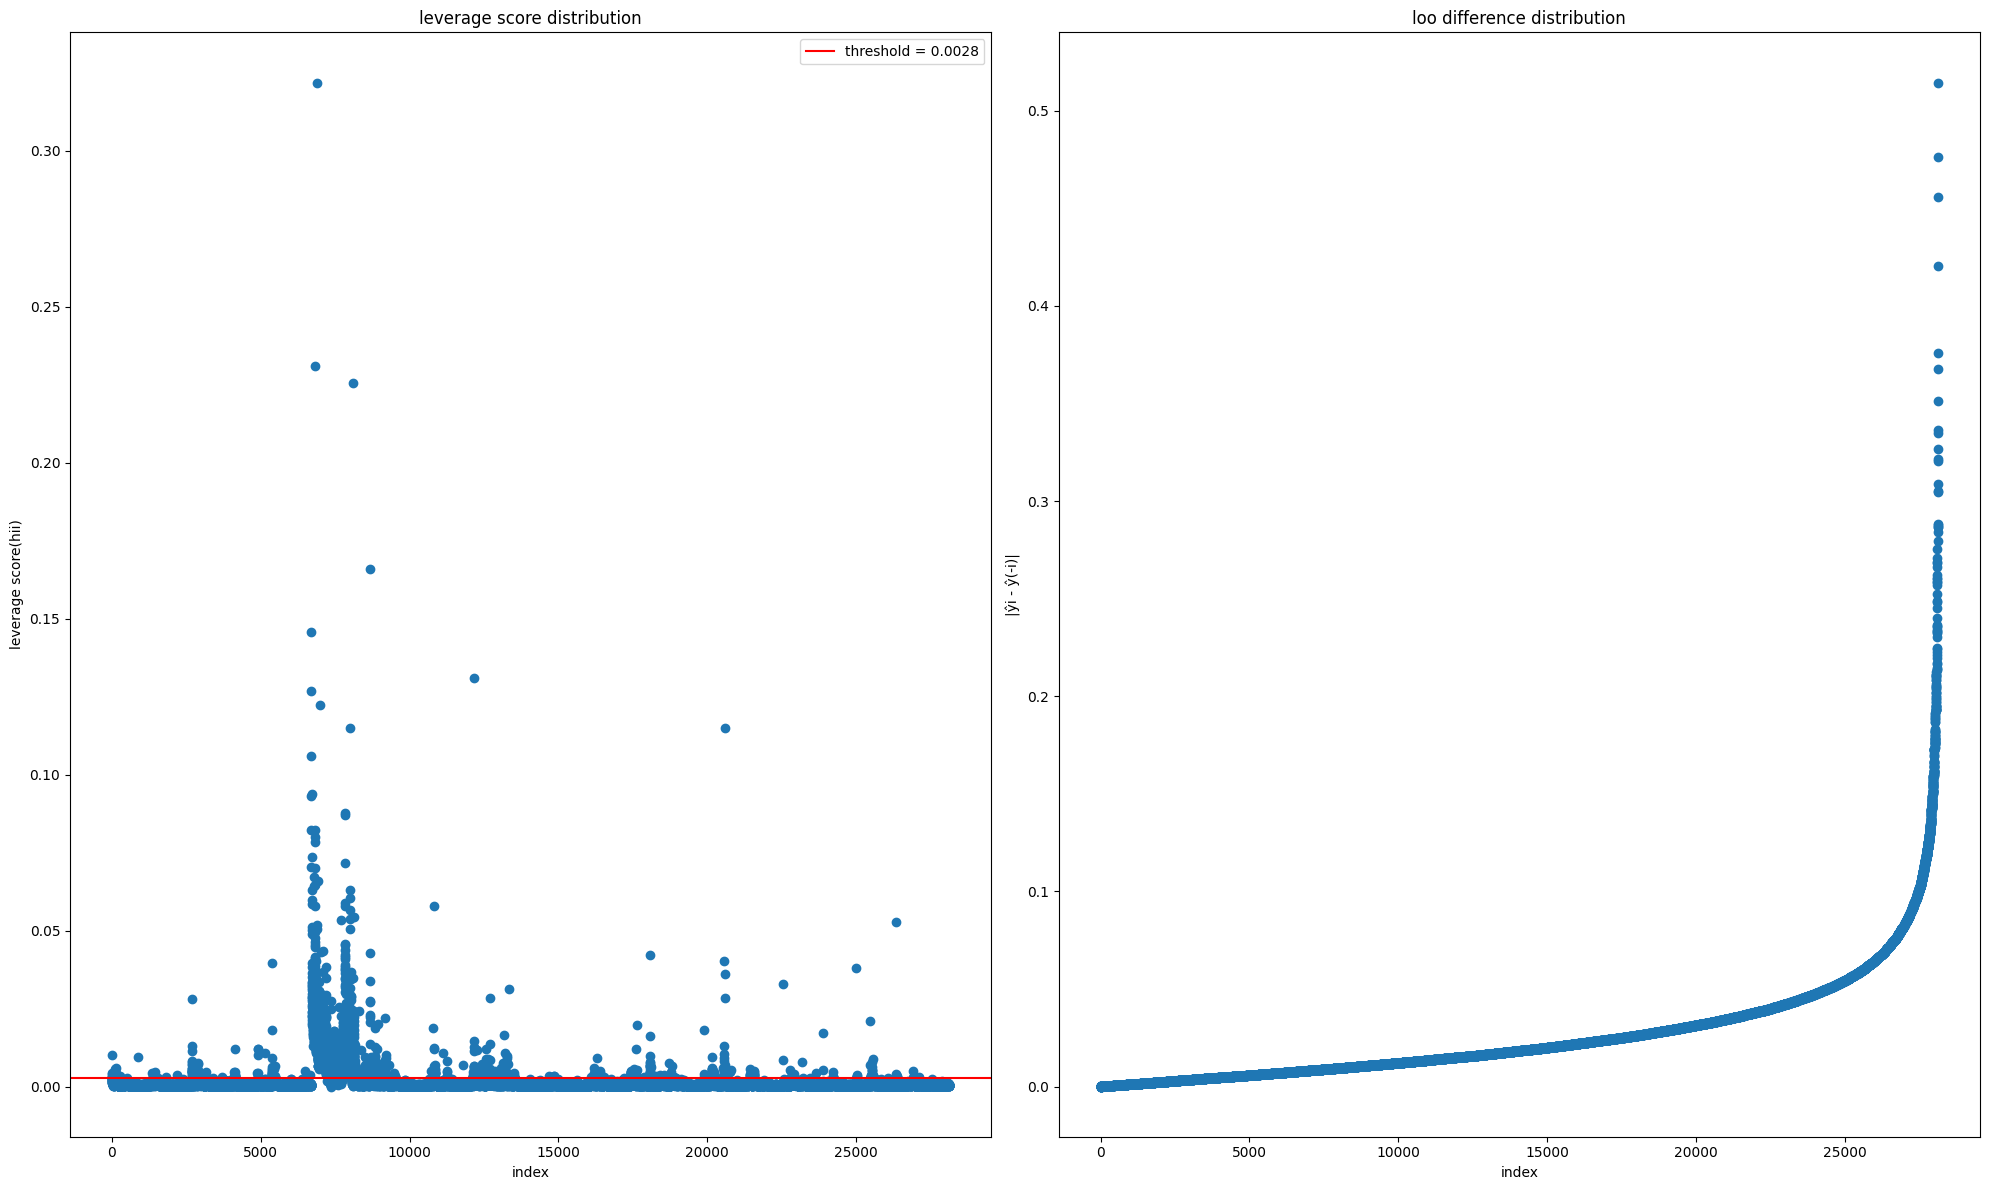

In [20]:
import warnings
warnings.filterwarnings('ignore')


print("\n杠桿分數(hii)統計量:")
print(f"最小值: {np.min(leverage_scores):.6f}")
print(f"1%分位數: {np.percentile(leverage_scores, 1):.6f}")
print(f"25%分位數: {np.percentile(leverage_scores, 25):.6f}")
print(f"中位數: {np.percentile(leverage_scores, 50):.6f}")
print(f"75%分位數: {np.percentile(leverage_scores, 75):.6f}")
print(f"99%分位數: {np.percentile(leverage_scores, 99):.6f}")
print(f"最大值: {np.max(leverage_scores):.6f}")

print("\n留一法預測差異(|ŷi - ŷ(-i)|)統計量:")
print(f"最小值: {np.min(y_loo_diff):.6f}")
print(f"1%分位數: {np.percentile(y_loo_diff, 1):.6f}")
print(f"25%分位數: {np.percentile(y_loo_diff, 25):.6f}")
print(f"中位數: {np.percentile(y_loo_diff, 50):.6f}")
print(f"75%分位數: {np.percentile(y_loo_diff, 75):.6f}")
print(f"99%分位數: {np.percentile(y_loo_diff, 99):.6f}")
print(f"最大值: {np.max(y_loo_diff):.6f}")


print("-"*100)
# 判斷是否有影響較大的觀測值
p = X_train.shape[1]  # 預測變量數量
threshold_leverage = 2 * p / n  # 杠桿分數閾值
print(f"\n杠桿分數閾值 (2P/N): {threshold_leverage:.6f}")
influential_leverage = np.sum(leverage_scores > threshold_leverage)
print(f"杠桿分數超過閾值的觀測值數量: {influential_leverage}")

# 繪製杠桿分數和留一法預測差異的散點圖
plt.figure(figsize=(20, 12))

plt.subplot(1, 2, 1)
plt.scatter(range(len(leverage_scores)), leverage_scores)
plt.axhline(y=threshold_leverage, color='r', linestyle='-', label=f'threshold = {threshold_leverage:.4f}')
plt.xlabel('index')
plt.ylabel('leverage score(hii)')
plt.title('leverage score distribution')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(range(len(y_loo_diff)), y_loo_diff)
plt.xlabel('index')
plt.ylabel('|ŷi - ŷ(-i)|')
plt.title('loo difference distribution')

plt.tight_layout()
plt.show()



### 3. 計算測試集RMSE

In [21]:

y_pred_test = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f"\n原始測試集RMSE: {rmse_test:.4f}")




原始測試集RMSE: 0.0385


### 4. 移除杠桿分數過高的觀測值並重新計算

In [22]:

mask_leverage = leverage_scores <= threshold_leverage
X_train_filtered = X_train[mask_leverage]
y_train_filtered = y_train[mask_leverage]

# 訓練新模型
model_filtered = LinearRegression()
model_filtered.fit(X_train_filtered, y_train_filtered)

# 計算新訓練集RMSE
y_pred_train_filtered = model_filtered.predict(X_train_filtered)
rmse_train_filtered = np.sqrt(mean_squared_error(y_train_filtered, y_pred_train_filtered))
print(f"\n移除高杠桿分數後的train RMSE: {rmse_train_filtered:.4f}")

# 計算新測試集RMSE
y_pred_test_filtered = model_filtered.predict(X_test)
rmse_test_filtered = np.sqrt(mean_squared_error(y_test, y_pred_test_filtered))
print(f"移除高杠桿分數後的test RMSE: {rmse_test_filtered:.4f}")
print(f"RMSE test difference : {(rmse_test_filtered - rmse_test):.4f}")
print(f"RMSE train difference : {(rmse_train_filtered - rmse_train):.4f}")




移除高杠桿分數後的train RMSE: 0.0348
移除高杠桿分數後的test RMSE: 0.0790
RMSE test difference : 0.0405
RMSE train difference : -0.0035


### 5. 移除留一法預測差異最大的三個觀測值並重新計算

In [23]:

# 找出留一法預測差異最大的三個觀測值的索引
top3_indices = np.argsort(y_loo_diff)[-3:]  # we need index not value
mask_loo = np.ones(len(y_train), dtype=bool)
mask_loo[top3_indices] = False

X_train_filtered2 = X_train[mask_loo]
y_train_filtered2 = y_train[mask_loo]



In [25]:
# 訓練新模型
model_filtered2 = LinearRegression()
model_filtered2.fit(X_train_filtered2, y_train_filtered2)

# 計算新訓練集RMSE
y_pred_train_filtered2 = model_filtered2.predict(X_train_filtered2)
rmse_train_filtered2 = np.sqrt(mean_squared_error(y_train_filtered2, y_pred_train_filtered2))
print(f"\n移除留一法預測差異最大的三個觀測值後的 train RMSE: {rmse_train_filtered2:.4f}")

# 計算新測試集RMSE
y_pred_test_filtered2 = model_filtered2.predict(X_test)
rmse_test_filtered2 = np.sqrt(mean_squared_error(y_test, y_pred_test_filtered2))
print(f"移除留一法預測差異最大的三個觀測值後的test RMSE: {rmse_test_filtered2:.4f}")
print(f"test RMSE變化: {(rmse_test_filtered2 - rmse_test):.4f}")
print(f"train RMSE變化: {(rmse_train_filtered2 - rmse_train):.4f}")




移除留一法預測差異最大的三個觀測值後的 train RMSE: 0.0383
移除留一法預測差異最大的三個觀測值後的test RMSE: 0.0385
test RMSE變化: 0.0000
train RMSE變化: 0.0000


In [26]:
# 結果比較
results = pd.DataFrame({
    '模型': ['原始模型', '移除高杠桿分數', '移除留一法預測差異最大的三個觀測值'],
    '訓練集RMSE': [rmse_train, rmse_train_filtered, rmse_train_filtered2],
    '測試集RMSE': [rmse_test, rmse_test_filtered, rmse_test_filtered2]
})

print("\n模型比較:")
print(results)




模型比較:
                  模型   訓練集RMSE   測試集RMSE
0               原始模型  0.038307  0.038479
1            移除高杠桿分數  0.034814  0.078989
2  移除留一法預測差異最大的三個觀測值  0.038308  0.038480


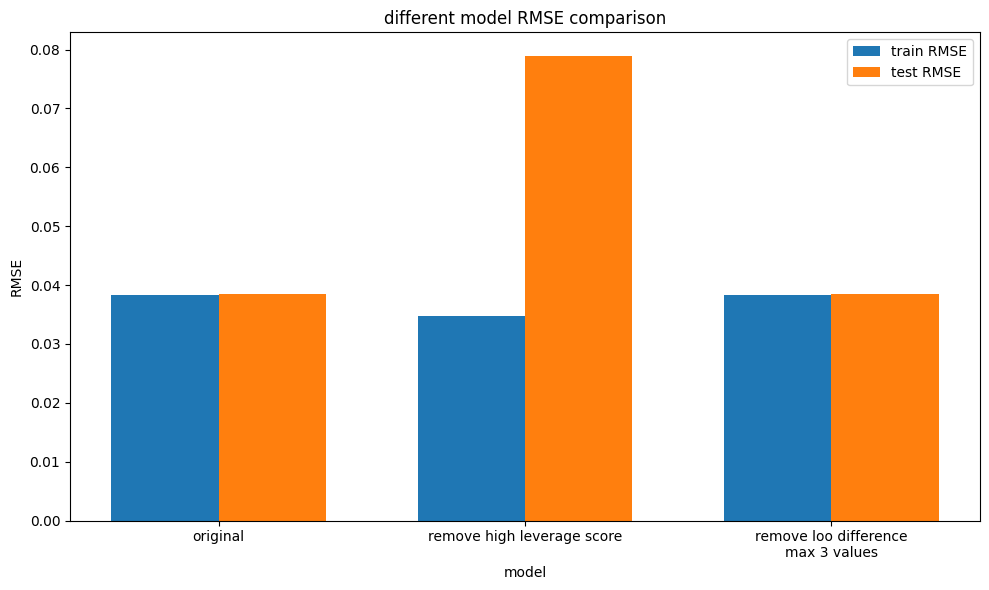

In [29]:
# 繪製結果比較圖
plt.figure(figsize=(10, 6))
bar_width = 0.35
x = np.arange(3)

plt.bar(x - bar_width/2, results['訓練集RMSE'], bar_width, label='train RMSE')
plt.bar(x + bar_width/2, results['測試集RMSE'], bar_width, label='test RMSE')

plt.xlabel('model')
plt.ylabel('RMSE')
plt.title('different model RMSE comparison')
plt.xticks(x, ['original', 'remove high leverage score', 'remove loo difference\nmax 3 values'])
plt.legend()
plt.tight_layout()
plt.show()